**Import required libraries**

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
from random import shuffle
import math

import random
import matplotlib.pyplot as plt
import math
import seaborn as sns
import pickle
from datetime import datetime
import pandas as pd
import sklearn_extra.cluster

In [71]:
def statusPrintInit(input_string):
    print("[STATUS]: Initializing", input_string)
    
def statusPrintEndInit(input_string):
    print("[STATUS]: Done with", input_string)

def statusPrintPlain(input_string):
    print("[STATUS]:", input_string)


In [72]:
class Connect2Model(nn.Module):

    def __init__(self, board_size, action_size, device):

        super(Connect2Model, self).__init__()

        self.device = device
        self.size = board_size
        self.action_size = action_size

        self.fc1 = nn.Linear(in_features=self.size, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)

        # Two heads on our network
        self.action_head = nn.Linear(in_features=64, out_features=self.action_size)
        self.value_head = nn.Linear(in_features=64, out_features=1)

        self.to(device)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        action_logits = self.action_head(x)
        value_logit = self.value_head(x)

        return F.softmax(action_logits, dim=1), value_logit

    def predict(self, board):
        board = torch.FloatTensor(board.astype(np.float32)).to(self.device)
        board = board.view(1, self.size)
        self.eval()
        with torch.no_grad():
            pi, v = self.forward(board)

        return pi.data.cpu().numpy()[0], v.data.cpu().numpy()[0]

In [73]:
import os
import numpy as np
from random import shuffle

import torch
import torch.optim as optim

class Trainer:

    def __init__(self, dl_model , model, args):
        self.dl_model = dl_model
        self.model = model
        self.args = args
        self.mcts = MCTS_DL(self.dl_model, self.model, self.args)
        self.scores_mcts_dl = np.array([])
        self.scores_greedy = np.array([])
        self.scores_random = np.array([])
        self.scores_mcts = np.array([])

    def exceute_episode(self, tmp, plotting):

        train_examples = []
        state = []

        while True:

            self.mcts = MCTS_DL(self.dl_model, self.model, self.args)
            root = self.mcts.run(state)
            
            action_probs = [0 for _ in range(self.model.n_clusters)]
            for k, v in root.children.items():
                action_probs[k] = v.visit_count

            action_probs = action_probs / np.sum(action_probs)
            train_examples.append((state, action_probs))

            action = root.select_action(temperature = tmp) # Action here is returned as an index of the action within the model.representatives list
            state = self.model.get_next_state(state, action) # This is where you actually get the song from the chosen cluster (selected in select_action) and 
            reward = self.model.get_reward(state)

            if reward is not None:
                ret = []
                for hist_state, hist_action_probs in train_examples:
                    # [Board, actionProbabilities, Reward]
                    ret.append((self.model.state_to_input(hist_state), hist_action_probs, reward))
                print(hist_state, reward)
                
                if plotting:
                    self.scores_mcts_dl = np.append(self.scores_mcts_dl, reward)
                    self.scores_greedy = np.append(self.scores_greedy, get_greedy_trajectory(self.model))
                    self.scores_random = np.append(self.scores_random, get_random_trajectory(self.model))
                    self.scores_mcts = np.append(self.scores_mcts, get_MCTS_trajectory(self.model))
                    plt.plot(self.scores_mcts_dl, label='DeepMCTS')
                    plt.plot(self.scores_mcts, label='Vanilla MCTS')
                    plt.plot(self.scores_greedy, label='Greedy policy')
                    plt.plot(self.scores_random, label='Random policy')
                    plt.legend()
                    plt.show()
                    
                return ret

    def learn(self, temperature):
        for i in range(1, self.args['numIters'] + 1):

            print("{}/{}".format(i, self.args['numIters']))

            train_examples = []

            for eps in range(self.args['numEps']):
                iteration_train_examples = self.exceute_episode(temperature, False)
                train_examples.extend(iteration_train_examples)

            self.exceute_episode(0, True)
            shuffle(train_examples)
            self.train(train_examples)
            filename = self.args['checkpoint_path']
            self.save_checkpoint(folder=".", filename=filename)

    def train(self, examples):
        optimizer = optim.Adam(self.dl_model.parameters(), lr=5e-4)
        pi_losses = []
        v_losses = []

        for epoch in range(self.args['epochs']):
          self.dl_model.train()

          batch_idx = 0

          while batch_idx < int(len(examples) / self.args['batch_size']):
            sample_ids = np.random.randint(len(examples), size=self.args['batch_size'])
            boards, pis, vs = list(zip(*[examples[i] for i in sample_ids]))
            boards = torch.FloatTensor(np.array(boards).astype(np.float64))
            target_pis = torch.FloatTensor(np.array(pis))
            target_vs = torch.FloatTensor(np.array(vs).astype(np.float64))

            # predict
            boards = boards.contiguous().cuda()
            target_pis = target_pis.contiguous().cuda()
            target_vs = target_vs.contiguous().cuda()

            # compute output
            out_pi, out_v = self.dl_model(boards)
            l_pi = self.loss_pi(target_pis, out_pi)
            l_v = self.loss_v(target_vs, out_v)
            total_loss = l_pi + l_v

            pi_losses.append(float(l_pi))
            v_losses.append(float(l_v))

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            batch_idx += 1
    

          print()
          print("Policy Loss", np.mean(pi_losses))
          print("Value Loss", np.mean(v_losses))
          # print("Examples:")
          # print(out_pi[0].detach())
          # print(target_pis[0])
          

    def loss_pi(self, targets, outputs):
        loss = -(targets * torch.log(outputs)).sum(dim=1)
        return loss.mean()

    def loss_v(self, targets, outputs):
        loss = torch.sum((targets-outputs.view(-1))**2)/targets.size()[0]
        return loss

    def save_checkpoint(self, folder, filename):
        if not os.path.exists(folder):
            os.mkdir(folder)

        filepath = os.path.join(folder, filename)
        torch.save({
            'state_dict': self.dl_model.state_dict(),
        }, filepath)

In [74]:
import pandas as pd
import os
import numpy as np
import itertools
import scipy.spatial.distance as distlib
import random as rand

class RecommendationSystem:
    def __init__(self, dataset_with_bins, n_features, n_bins):
        '''
        We assume here that the columns of the dataset here are already the binary percentile bins for all features 
        For sanity check: n_features x n_bins = length(dataset_with_bins)
        '''
        statusMsg = 'recommendation system class'
        statusPrintInit(statusMsg)
        self.data = dataset_with_bins # assuming this is the whole dataset split that we want to work with
        self.data.index = np.arange(np.shape(self.data)[0])
        self.n_features = n_features
        self.n_bins = n_bins
        self.k_t = 10 # for now, just queue the user 10 songs to choose from
        self.k_s = 10
        self.var_param = 100 # parameter that determines the "variance" of the user reference distribution that the user song picks are generated from
        self.initial_songs = self.gen_user_song_picks() # assuming this is still a pandas df of k_s rows, but only containing the song rows that the user prefers
        
        # Initialize preferences
        self.init_song_preferences()
        self.init_transition_preferences()
        statusPrintEndInit(statusMsg)

    def init_song_preferences(self):
        statusMsg = "song preferences"
        statusPrintInit(statusMsg)
        # Initialize preference array
        self.phi_s = (1/((self.k_s + 1) * self.n_bins)) * np.ones((self.n_features * self.n_bins, 1))
        tmp = (np.sum(self.initial_songs.values, axis = 0)) * (1/(self.k_s + 1))
        self.phi_s = self.phi_s + np.reshape(tmp, (len(tmp), 1))
        statusPrintEndInit(statusMsg)

    def theta_t(self, idx_a, idx_b):
        '''
        Input: indices of songs a and b within the provided dataset (int)

        Output: vector theta_t, assuming the feature sequence of 1-i, 1-2, ..., 1-n_bins, 2-1, ..., n_bins-1, n_bins-2, ..., n_bins-n_bins
        '''
        indices = np.array([], dtype=int)
        for i in range(self.n_features):
            a_bin_idx = np.where(self.data.loc[idx_a][self.data.columns[i*self.n_bins:(i+1)*self.n_bins]] == 1.0)[0]
            b_bin_idx = np.where(self.data.loc[idx_b][self.data.columns[i*self.n_bins:(i+1)*self.n_bins]] == 1.0)[0]
            indices = np.append(indices, int(i*(self.n_bins*self.n_bins) + a_bin_idx*self.n_bins + b_bin_idx))
        out = np.zeros((self.n_bins * self.n_bins * self.n_features, 1))
        out[indices] = 1
        return out

    def init_transition_preferences(self):
        statusMsg = "transition preferences"
        statusPrintInit(statusMsg)
        # Take the upper-median preference split
        self.Rs = np.sum(np.matmul(self.data.values, self.phi_s), axis=1)
        self.Mstar = self.data.copy()
        self.Mstar['Rs'] = self.Rs
        self.Mstar.sort_values('Rs', inplace = True, ascending = False)
        self.Mstar = self.Mstar[:np.shape(self.Mstar)[0] // 2]
        self.Mstar['old_index'] = self.Mstar.index
        self.Mstar.index = np.arange(np.shape(self.Mstar)[0])

        # Generate 10th percentile distance of all pairwise distances from M (not M*)
        self.diff = distlib.pdist(self.data.values, 'cosine')
        self.delta = np.percentile(self.diff, 10, axis=0)
        self.distances = distlib.squareform(self.diff)
        np.fill_diagonal(self.distances, np.inf)

        # Generate a representative subset of M*
        self.representatives, self.clusters_t = self.delta_medoids(self.Mstar, self.delta, True)
        song_prev = np.random.choice(self.representatives)

        if self.k_t > len(self.representatives):
            print("[WARNING] k_t parameter too large for generated representative subset. Consider using a larger dataset or reducing k_t value")
            print("Setting k_t =", len(self.representatives), "to match the generated number of representatives through delta-medoids")
            self.k_t = len(self.representatives)

        song_prev = np.random.choice(self.representatives)
        self.representatives = np.delete(self.representatives, np.argwhere(self.representatives == song_prev))

        self.phi_t = (1/(self.k_t * self.n_bins*self.n_bins)) * np.ones((self.n_features * self.n_bins * self.n_bins, 1))

        for i in range(self.k_t-1):
            next_song, theta = self.pick_next_song(song_prev, self.user_ref_samples_t[:, i])
            self.phi_t += (1/(self.k_t)) * theta
            song_prev = next_song
            
        statusPrintEndInit(statusMsg)

 

    def one_shot_delta(self, data, delta, clusters, init):
        # Remember to change the distance metric in case we change delta distance definition
        if init:
            distances = distlib.pdist(data[data.columns[:-2]], 'cosine')
        else:
            distances = distlib.pdist(data, 'cosine') # Same as for delta medoids method
        distances = distlib.squareform(distances)
        representatives_init = np.array(list(clusters.keys()), dtype = 'int32')
        clusters = dict(zip(representatives_init, [np.array([], dtype='int32') for _ in range(len(representatives_init))])) # We want to start with a dictionary with the keys being there, but the elements being empty, as all elements will be reassigned anyways
        for index, row in data.iterrows():
            dist = 1e6
            representatives = np.array(list(clusters.keys()), dtype = 'int32')
            if len(representatives) > 0:
                rep = np.intersect1d(np.where(distances[:, index] == np.min(distances[:, index][representatives]))[0], representatives) # Take the intersection to make sure we select the correct index belonging to the set of representatives
                
                if len(rep) > 1:
                    if index not in rep: # Check if already in rep --> we do not want to add it to another cluster if it is already a representative (in case index and another song have the same feature vectors, miraculously)
                        rep = rep[0]
                    else:
                        rep = index
                else:
                    rep = int(rep)
                dist = distances[rep, index]
            if dist <= delta:
                clusters[rep] = np.append(clusters[rep], index)
            else: 
                clusters[index] = np.array([index])

        dbg = np.sum([len(val) for val in clusters.values()])
        if dbg != np.shape(data)[0]:
            print("WARNING: stuff going wrong here, generated list of cluster elements does not sum up to the total size of the song dataset selected")
        return clusters

    def delta_medoids(self, data, delta, init):
        statusMsg = "delta medoids"
        statusPrintInit(statusMsg)
        if init:
            distances = distlib.pdist(data[data.columns[:-2]], 'cosine')
        else:
            distances = distlib.pdist(data, 'cosine') # When we want to use it to generate normal clusters of the whole dataset - we do not have anything appended, so use all columns
        distances = distlib.squareform(distances)
        np.fill_diagonal(distances, 0)
        exit_loop = False
        i = 0
        clusters = {}
        while not exit_loop:
            i +=1
            clusters = self.one_shot_delta(data, delta, clusters, init)
            if 1 != i:
                representatives_prev = representatives
            else:
                representatives_prev = np.array([], dtype = 'int32')
            representatives = np.array([], dtype = 'int32')
            for cluster in clusters.items():
                cluster = cluster[1]
                cluster_dists = distlib.pdist(data.loc[cluster], 'cosine')
                cluster_dists = distlib.squareform(cluster_dists)
                argmin = np.argmin(np.sum(cluster_dists, axis=0))
                representatives = np.append(representatives, cluster[argmin])
            
            if np.array_equal(np.sort(representatives), np.sort(representatives_prev)):
                exit_loop = True
                

        # Convert back to indices of the original data array
        if init:
            representatives = data['old_index'][np.in1d(data.index, representatives)].values # Do not need to convert back if clustering songs together for action space reduction, as we preserve the old indices anyways
        statusPrintEndInit(statusMsg)
        return representatives, clusters

    def pick_next_song(self, previous_song, reference):
        reference = np.reshape(reference, (len(reference), 1))
        min_dist = 1e06
        for song in self.representatives:
            theta_current = self.theta_t(previous_song, song)
            dist = distlib.cosine(theta_current, reference)
            if dist < min_dist:
                min_theta = theta_current
                min_song = song
                min_dist = dist

        self.representatives = np.delete(self.representatives, np.argwhere(self.representatives == min_song)[0])
        return min_song, min_theta
    
    def gen_user_song_picks(self):
        """
        Returns a subset of the dataframe of k_s songs closest to the random samples generated from the user preference distribution, simulating picked user reference
        The user reference distribution is generated here and can be accessed through self.user_ref
        """
        self.user_ref_s, self.user_ref_samples_s, self.user_ref_t, self.user_ref_samples_t  = self.gen_user_ref()
        sample_index = np.arange(np.shape(self.data)[0], np.shape(self.data)[0] + self.k_s, dtype='int32')
        to_append = pd.DataFrame(np.transpose(self.user_ref_samples_s), index = sample_index)
        sample = self.data.copy().append(to_append)
        dists_with_samples = distlib.pdist(sample, metric='cosine')
        dists_with_samples = distlib.squareform(dists_with_samples)
        np.fill_diagonal(dists_with_samples, np.inf)
        user_selected_songs = np.array([], dtype='int32')

        for i in sample_index:
            min_ind = np.argmin(dists_with_samples[:sample_index[0], i])
            user_selected_songs = np.append(user_selected_songs, min_ind)
            dists_with_samples[min_ind, :] = np.inf #Do not allow to pick this row anymore
        return self.data.loc[user_selected_songs]
        

    def gen_user_ref(self):
        '''
        Generates a random "ground-truth" user song and transitions preference distributions over features (kind of
        like a ground-truth phi_s and phi_t), as well as k_s for songs (and k_t, for transitions, respectively) samples from it, that are later used to 
        simulate user song preferences and transition preferences that the user preference vectors phi_s and phi_t are learned from

        Input: var_param: a parameter that alters the variance of the distribution over each feature of the ground truth user preference vectors, int

        Output: - user_reference_s (numpy array, n_bins x n_features, 1): ground-truth user song preference distribution over each feature
                - user_samples_s (numpy array, n_bins x n_features, k_s): k_s samples of the "ground truth phi_s", used to select initial, user-preferred songs
                - user_reference_t (numpy array, n_bins*n_bins x n_features, 1): ground-truth user transition preference distribution over each feature
                - user_samples_t (numpy array, n_bins*n_bins x n_features, k_t): k_t samples of the "ground truth phi_t", used to select songs that the user preference phi_t will be estimated from 
        '''
    
        user_reference_s = np.array([])
        user_reference_t = np.array([])

        user_samples_s = np.zeros((self.n_features * self.n_bins, self.k_s))
        user_samples_t = np.zeros((self.n_features * self.n_bins * self.n_bins, self.k_t))

        for i in range(self.n_features):
            vec_s = np.random.randint(1, self.var_param, (self.n_bins, ))
            vec_s = vec_s/np.sum(vec_s)
            user_reference_s = np.append(user_reference_s, vec_s)
            sample_bins_s = np.array(rand.choices(np.arange(self.n_bins, dtype='int32'), vec_s, k = self.k_s))
            user_samples_s[i*self.n_bins + sample_bins_s, np.arange(self.k_s, dtype='int32')] = 1
            
            vec_t = np.random.randint(1, self.var_param, (self.n_bins * self.n_bins, ))
            vec_t = vec_t/np.sum(vec_t)
            user_reference_t = np.append(user_reference_t, vec_t)
            sample_bins_t = np.array(rand.choices(np.arange(self.n_bins * self.n_bins, dtype='int32'), vec_t, k = self.k_t))
            user_samples_t[i*self.n_bins*self.n_bins + sample_bins_t, np.arange(self.k_t, dtype='int32')] = 1

        return user_reference_s, user_samples_s, user_reference_t, user_samples_t

In [75]:
def ucb_score(parent, child):
    """
    The score for an action that would transition between the parent and child.
    """
    if child.prior < 0.0001:
      return -100000000
    prior_score = child.prior * math.sqrt(parent.visit_count) / (child.visit_count + 1)
    if child.visit_count > 0:
        # The value of the child is from the perspective of the opposing player
        value_score = child.value()
    else:
        value_score = 100000

    return value_score + prior_score

In [76]:
class MDP:
    def __init__(self, file_name, playlist_length, n_clusters):
        statusMsg = "MDP  class"
        statusPrintInit(statusMsg)
        df = pd.read_csv(file_name, index_col=None)

        self.features = ['duration', 'key_confidence', 'end_of_fade_in', 'mode_confidence', 'start_of_fade_out', 'tempo',
                    'artist_hotttnesss', 'song_hotttnesss']

        for feature in self.features:
          filter = df[feature] > 0
          df = df[filter]
        
        self.filtered_df = df[self.features]
        self.filtered_df.dropna(inplace=True)

        # self.filtered_df = self.filtered_df.head(100)
        
        self.n_clusters = n_clusters
        self.filtered_df = self.filtered_df.reset_index(drop=True)
        self.n_rows = len(self.filtered_df.index)
        self.n_songs = self.n_rows
        self.n_bins = 10
        self.n_features = len(self.features)
        self.id_song_to_vec = dict()
        self.songs = set()        
        self.song_id_to_song_row = []
        self.cluster_priors = []
        self.playlist_length = playlist_length
        self.id_song_to_features = dict()

        song_id = 0

        statusPrintPlain("generating feature vectors")
        for song, row in self.filtered_df.iterrows():
            self.id_song_to_vec[song_id] = np.zeros(80)
            self.id_song_to_features[song_id] = np.zeros(self.n_features)

            for f in range(self.n_features):
              feature = self.features[f]
              self.id_song_to_features[song_id][f] = row[feature]

            self.songs.add(song_id)
            self.song_id_to_song_row.append(row)
            song_id += 1

        self.cluster_priors = np.ones(self.n_clusters)

        self.songs_list = [i for i in range(self.n_songs)]

        for f in range(self.n_features):

            feature = self.features[f]
            sorted_df = self.filtered_df.sort_values(by=[feature])
            i = 0
            for idx, row in sorted_df.iterrows():
                bin = i * self.n_bins // self.n_rows
                self.id_song_to_vec[idx][f * 10 + bin] = 1
                i += 1


        df_input = pd.DataFrame.from_dict(self.id_song_to_vec, orient='index')
        # Select songs that the user prefers (randomly selecting 5 for now, change later)
        self.init_prefs = df_input.loc[rand.sample(self.songs, 5)]

        self.rs = RecommendationSystem(df_input, self.n_features, self.n_bins)
        self.phi_s = self.rs.phi_s.reshape(80)
        self.phi_t = self.rs.phi_t.reshape(800)
        self.delta_action_clustering = self.rs.delta # Try out this delta for now 

        statusPrintPlain("Generating song clusters for action space reduction")
        km = sklearn_extra.cluster.KMedoids(n_clusters = self.n_clusters).fit(self.filtered_df.values)
        self.representatives = km.medoid_indices_
        self.cluster_assignment = km.labels_
        self.clusters = dict(zip(km.medoid_indices_, [np.where(km.labels_ == rep_idx)[0] for rep_idx in range(len(km.medoid_indices_))]))

        self.transition_reward = np.zeros((self.n_songs, self.n_songs))

        statusPrintPlain("Fetching the pre-computed song transition rewards")
        self.transition_reward = np.load('./data/transition_rewards.npy') # Replaced this by a pre-computed file with the whole 2886 cleaned-up dataset included, as otherwise it takes 50 minutes to compute this every time
        self.song_reward = np.zeros(self.n_songs)
        for i in range(self.n_songs):
          self.song_reward[i] = np.dot(self.phi_s, self.theta_s(i))

        statusPrintEndInit(statusMsg)

    def get_next_state(self, state, action_in):
      action = self.representatives[action_in] # The input action is actually the index of the representative cluster, not the song number of the representative of the cluster (as generated through node.expand())
      select_from = np.array(list(set(self.clusters[action]) - set(state)))
      next_idx = np.random.randint(0, len(select_from)) 
      self.next_song = select_from[next_idx] # We save it locally within the class as we make use of it in some instances after calling the method
      return state + [self.next_song]


    def get_valid_random_cluster_index(self, valid_actions):
        return np.where(self.representatives == np.random.choice(valid_actions))[0][0]
      
    def get_valid_actions(self, state):
        # All actions are invalid by default
        valid_actions = [0] * self.n_clusters
        i = 0

        for rep in self.clusters.keys():
            if np.array(list(set(self.clusters[rep]) - set(state))).size != 0: # Check if each cluster still has songs that have not been selected in the playlist yet
                valid_actions[i] = 1
            i += 1

        return valid_actions

    def get_song_cluster(self, song):
        return self.representatives[self.cluster_assignment[song]]

    def state_to_input(self, state):
      input = np.ones(self.playlist_length*self.n_features*10)*-1
      for i in range(len(state)):
        song = state[i]
        input[i*self.n_features*10:(i+1)*self.n_features*10] = self.id_song_to_vec[song]
      return input

    def get_reward(self, final_state):
      if len(final_state) < self.playlist_length:
        return None
      elif len(final_state) == self.playlist_length:
        state = []
        trajectory_states = [state]
        trajectory_actions = []
        
        for song in final_state:
          state.append(song)
          trajectory_states.append(state)
          trajectory_actions.append(song)
          
        return self.payoff_trajectory(trajectory_states, trajectory_actions)

      else:
        print("Error: length > self.playlist_length")
        return None


    def get_theta_t(self, s1, s2):
        theta_t = np.zeros(800)
        for f in range(len(self.features)):
            for i in range(10):
                for j in range(10):
                    if self.id_song_to_vec[s1][f*10 + i] == 1 and  self.id_song_to_vec[s2][f*10 + j]:
                        theta_t[f*100 + i*10 + j] = 1
        return  theta_t

    def theta_s(self, s):
        return self.id_song_to_vec[s]

    def R(self, s, a):
        Rs = self.song_reward[a]
        Rt = 0
        for i in range(len(s)):
            song_past = s[len(s)-i-1]
            Rt += 1/((i+1)**(0.1)) * self.transition_reward[song_past,a]
        return Rs + Rt


    def payoff_trajectory(self, trajectory_states, trajectory_actions):
      payoff = 0

      for t in range(len(trajectory_actions)):
        payoff +=  self.R(trajectory_states[t], trajectory_actions[t])
      return payoff

    def MC_value(self, s):
      count = 0
      sum_values = 0
      state = s
      # Past episodes
      episode_states = [[]]
      episode_actions = []

      for i in range(model.playlist_length):
        if i < len(s):
          state = s[:i+1]
          action = s[i]
        else:
          action_probs = list(self.cluster_priors)
          j = 0
          for cluster_id in self.clusters.keys():
            if np.in1d(self.clusters[cluster_id], state).all():
              action_probs[j] = 0
            j += 1

          action_probs = np.array(action_probs)/np.sum(np.array(action_probs))
          action_cluster = np.random.choice(list(self.clusters.keys()), 1, p = action_probs)[0]
          action = np.random.choice(self.clusters[action_cluster])
          state = episode_states[-1] + [action]

        episode_states.append(state)
        episode_actions.append(action)

      # print("MC estimate:", s, episode_states, episode_actions)
          
      # Set MC 
      payoff = self.payoff_trajectory(episode_states, episode_actions)
      
      return payoff

class Node:
    def __init__(self, prior):
        self.visit_count = 0
        self.prior = prior
        self.value_sum = 0
        self.children = {}
        self.state = None

    def expanded(self):
        return len(self.children) > 0

    def value(self):
        if self.visit_count == 0:
            return 0
        return self.value_sum / self.visit_count

    def select_action(self, temperature):
        """
        Select action according to the visit count distribution and the temperature.
        """
        visit_counts = np.array([child.visit_count for child in self.children.values()])
        actions = [action for action in self.children.keys()]
        
        if temperature == 0:
            action = actions[np.argmax(visit_counts)]

        elif temperature == float("inf"):
            action = np.random.choice(actions)

        else:
            # See paper appendix Data Generation
            visit_count_distribution = visit_counts ** (1 / temperature)
            visit_count_distribution = visit_count_distribution / sum(visit_count_distribution)
            action = np.random.choice(actions, p=visit_count_distribution)


        # The action returned here would be the index of the cluster in which the selected song resides
        return action

    def select_child(self):
        """
        Select the child with the highest UCB score.
        """
        best_score = -np.inf
        best_action = -1
        best_child = None

        for action, child in self.children.items():
            score = ucb_score(self, child)
            if score > best_score:
                best_score = score
                best_action = action
                best_child = child

        return best_action, best_child

    def expand(self, state, action_probs):
        """ 
        We expand a node and keep track of the prior policy probability given by neural network
        We return the cluster index (the index of the representative cluster song within model.representatives list)
        """
        self.state = state
        for cluster_idx in range(len(action_probs)):
              self.children[cluster_idx] = Node(action_probs[cluster_idx])

    def __repr__(self):
        """
        Debugger pretty print node info
        """
        prior = "{0:.2f}".format(self.prior)
        return "{} Prior: {} Count: {} Value: {}".format(self.state.__str__(), prior, self.visit_count, self.value())


In [77]:
import torch
import math
import numpy as np

class MCTS_DL:

    def __init__(self, dl_model, model, args):
        self.dl_model = dl_model
        self.model = model
        self.args = args

    def run(self, state):
        root = Node(0)

        # EXPAND root
        action_probs, value = self.dl_model.predict(self.model.state_to_input(state))
        valid_actions = self.model.get_valid_actions(state)
        action_probs = action_probs * valid_actions  # mask invalid moves
        action_probs /= np.sum(action_probs)
        root.expand(state, action_probs)

        for _ in range(self.args['num_simulations']):
            node = root
            search_path = [node]

            # SELECT
            while node.expanded():
                action, node = node.select_child()
                search_path.append(node)

            parent = search_path[-2] # Parent of the current node, non-expanded
            state = parent.state 

            # Above until here, we are just traversing the tree over nodes that we have already visited before. Afterwards, we select a node 

            # Now we're at a leaf node and we would like to expand
            # Players always play from their own perspective
            next_state = self.model.get_next_state(state, action)
            # Get the board from the perspective of the other player

            # The value of the new state from the perspective of the other player
            value = self.model.get_reward(next_state)
            if value is None:  # Is this is not supposed to be a while loop instead of a conditional? Otherwise one simulation will just always stop at a leaf node + 1, instead of the actual playlist length --> no guarantee that we have explored any path of length that is equal to the playlist length within the number of simulations
                # If the game has not ended:
                # EXPAND

                action_probs, value = self.dl_model.predict(self.model.state_to_input(next_state))
                valid_actions = self.model.get_valid_actions(next_state)

                action_probs = action_probs * valid_actions  # mask invalid moves
                action_probs /= np.sum(action_probs)

                node.expand(next_state, action_probs)

            self.backpropagate(search_path, value)

        return root

    def backpropagate(self, search_path, value):
        """
        At the end of a simulation, we propagate the evaluation all the way up the tree
        to the root.
        """
        for node in reversed(search_path):
            node.value_sum += value 
            node.visit_count += 1

In [78]:
class MCTS:

    def __init__(self, model, args):
        self.model = model
        self.args = args

    def run(self, root_state):
        root = Node(0)
        # EXPAND root
        action_probs = list(self.model.cluster_priors)
        i = 0

        for cluster_id in self.model.clusters.keys():
            if self.model.clusters[cluster_id].size == 0:
                action_probs[i] = 0
            i += 1
        
        action_probs /= np.sum(action_probs)
        root.expand(root_state, action_probs)

        for _ in range(self.args['num_simulations']):

            node = root
            search_path = [node]

            # SELECT
            while node.expanded():              
                action, node = node.select_child()
                search_path.append(node)
            parent = search_path[-2]
            state = parent.state
            # # Now we're at a leaf node and we would like to expand
            # # Players always play from their own perspective
            # next_state, _ = self.game.get_next_state(state, action=action)
            # # Get the board from the perspective of the other player
            # next_state = self.game.get_canonical_board(next_state, )

            # The value of the new state from the perspective of the other player
            # value = self.game.get_reward_for_player(next_state)
            next_state = parent.state + [action]

            value = model.MC_value(next_state)

            action_probs = list(self.model.cluster_priors)
            k = 0

            for cluster_id in self.model.clusters.keys():
                if np.array(list(set(self.model.clusters[cluster_id]) - set(next_state))).size == 0:
                    action_probs[k] = 0
                k += 1

            node.expand(next_state, action_probs)
        

            # if value is None:
                # If the game has not ended:
                # EXPAND
                # action_probs, value = model.predict(next_state)
                # valid_moves = self.game.get_valid_moves(nesxt_state)
                # action_probs = action_probs * valid_moves  # mask invalid moves
                # action_probs /= np.sum(action_probs)
                # node.expand(next_state, action_probs)

            self.backpropagate(search_path, value)

        return root

    def backpropagate(self, search_path, value):
        """
        At the end of a simulation, we propagate the evaluation all the way up the tree
        to the root.
        """
        for node in reversed(search_path):
            node.value_sum += value
            node.visit_count += 1


In [79]:
def get_random_trajectory(model):
  state = []
  trajectory_states = [state]
  trajectory_actions = []

  for i in range(playlist_length):
    
    valid_actions_bin = np.array(model.get_valid_actions(state)) == 1
    valid_actions = model.representatives[valid_actions_bin]
    action = model.get_valid_random_cluster_index(valid_actions)
    state = model.get_next_state(state, action)

    trajectory_states.append(state)
    trajectory_actions.append(model.next_song)

  cum_rewards = model.payoff_trajectory(trajectory_states, trajectory_actions)
  return cum_rewards

def get_greedy_trajectory(model):
  state = []
  trajectory_states = [state]
  trajectory_actions = []
  
  for i in range(playlist_length):
    max_score = -np.inf
    max_action = -1
    for try_action in range(model.n_clusters):
      if np.array(list(set(model.clusters[model.representatives[try_action]]) - set(state))).size == 0:
        continue #Skip if cluster associated with try_action is empty
      else: 
        try_state = model.get_next_state(state, try_action)
        try_trajectory_states = list(trajectory_states)
        try_trajectory_actions = list(trajectory_actions)
        try_trajectory_states.append(try_state)
        try_trajectory_actions.append(model.next_song)
        score = model.payoff_trajectory(try_trajectory_states, try_trajectory_actions)

        if score > max_score:
          max_song = model.next_song # saved within the MDP class when get_next_state is called
          max_score = score
    
    state.append(max_song)
    trajectory_states.append(state)
    trajectory_actions.append(max_song)

  cum_rewards = model.payoff_trajectory(trajectory_states, trajectory_actions)

  return cum_rewards

def get_MCTS_trajectory(model):
  # MCTS

  mcts = MCTS(model, args)
  trajectory_states = [[]]
  trajectory_actions = []
  state = []
  
  for i in range(playlist_length):
    root = mcts.run(state)
    counts = [node.visit_count for node in root.children.values()]
    for j in range(len(counts)):
      if j in np.where(np.array(model.get_valid_actions(state)) == 0)[0]:
        counts[j] = 0 # Make sure that invalid actions do not get selected
    max_val = max(counts)
    cluster_id = counts.index(max_val)
    state = model.get_next_state(state, cluster_id)
    song = model.next_song
    trajectory_states.append(state)
    trajectory_actions.append(song)
    # print(counts, max_index, state)
    for action, child in root.children.items():
      score = ucb_score(root, child)
      # print(child.state, score)

  cum_rewards =  model.payoff_trajectory(trajectory_states, trajectory_actions)
  return cum_rewards

[STATUS]: Initializing MDP  class
[STATUS]: generating feature vectors


/tmp/ipykernel_14358/19409842.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.filtered_df.dropna(inplace=True)


[STATUS]: Initializing recommendation system class
[STATUS]: Initializing song preferences
[STATUS]: Done with song preferences
[STATUS]: Initializing transition preferences
[STATUS]: Initializing delta medoids
[STATUS]: Done with delta medoids
[STATUS]: Done with transition preferences
[STATUS]: Done with recommendation system class
[STATUS]: Generating song clusters for action space reduction
[STATUS]: Fetching the pre-computed song transition rewards
[STATUS]: Done with MDP  class
1/50
[760, 1841, 2646, 2696, 1296, 1016, 418, 2001, 1553] 17.679796535773946
[763, 2303, 1659, 2646, 1071, 1540, 418, 809, 1457] 15.638818054763066
[763, 759, 644, 2303, 731, 2072, 1241, 1032, 285] 16.18750811359037
[1841, 100, 763, 2646, 1032, 573, 1241, 909, 391] 17.233649764517835
[1841, 1336, 345, 2303, 763, 1032, 1241, 573, 2168] 17.898812710665272
[763, 644, 167, 1249, 2329, 1841, 2303, 1032, 2139] 16.217382279460352


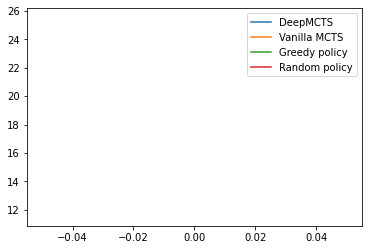


Policy Loss 4.42614761988322
Value Loss 263.24402872721356

Policy Loss 4.3717005252838135
Value Loss 255.6489461263021
2/50
[2001, 1361, 418, 869, 1016, 1553, 1436, 2369, 1032] 19.342087938428218
[760, 1540, 68, 781, 1723, 2704, 1281, 1032, 2236] 15.305457799545588
[763, 5, 1421, 2076, 1561, 644, 1183, 1180, 1540] 19.341938030192598
[1087, 1016, 763, 2631, 937, 68, 1956, 1831, 400] 14.405079562994564
[2696, 2599, 1841, 2830, 813, 2001, 763, 1540, 1666] 15.520653648067096
[763, 644, 167, 1249, 2329, 1841, 2303, 1032, 2139] 17.840745598555138


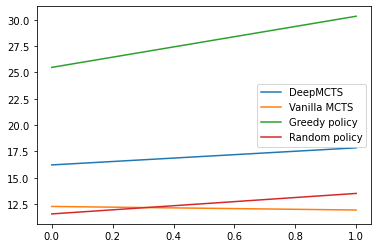


Policy Loss 4.0568123658498125
Value Loss 220.59294637044272

Policy Loss 3.9061607917149863
Value Loss 199.71817525227866
3/50
[418, 327, 1841, 869, 1470, 345, 1540, 820, 461] 15.385230259022117
[2327, 1540, 657, 418, 1710, 2225, 327, 763, 2132] 18.823415683860272
[43, 1891, 1540, 68, 869, 2704, 1032, 1798, 1648] 17.190078496557668
[68, 1540, 1721, 2608, 418, 1841, 763, 2674, 1230] 14.594333460839414
[332, 1841, 1553, 68, 869, 1981, 418, 763, 2696] 17.478963407882468
[763, 644, 167, 1249, 2329, 1841, 2303, 1032, 2139] 15.854986518226081


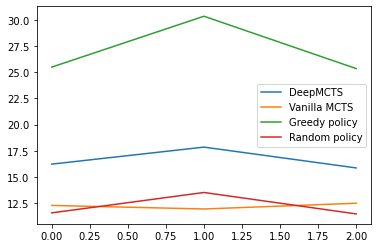


Policy Loss 3.548853317896525
Value Loss 143.71026102701822

Policy Loss 3.4607025384902954
Value Loss 127.5738894144694
4/50
[2457, 2725, 1553, 418, 763, 2696, 1118, 1953, 2001] 13.890196917248119


KeyboardInterrupt: 

In [81]:
import torch
import math
import pandas as pd
import numpy as np
import random as rand
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
from datetime import datetime

import scipy.spatial.distance as distlib
playlist_length = 10
n_clusters = 100 # Also equals to the action space size
model = MDP('MSD.csv', playlist_length, n_clusters)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

args = {
    'batch_size': 16,
    'numIters': 50,                                # Total number of training iterations
    'num_simulations': 10,                         # Total number of MCTS simulations to run when deciding on a move to play
    'numEps': 5,                                  # Number of full games (episodes) to run during each iteration
    'numItersForTrainExamplesHistory': 20,
    'epochs': 2,                                    # Number of epochs of training per iteration
    'checkpoint_path': 'latest.pth'                 # location to save latest set of weights
}

dl_model = Connect2Model(model.n_features*model.playlist_length*10, n_clusters, device)
# print(model.n_songs)
trainer = Trainer(dl_model, model, args)

trainer.learn(1)
data = {"MCTS": trainer.scores_mcts,
        "MCTS_DL": trainer.scores_mcts_dl,
        "GREEDY": trainer.scores_greedy,
        "RANDOM": trainer.scores_random}

with open(filepath+'{}_{}_{}_{}.pickle'.format(datetime.now().strftime("%y%m%d%H%M%S"), args['numIters'], args['num_simulations'], args['numEps']), 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(filepath+'{}_{}_{}_{}.pickle'.format(datetime.now().strftime("%y%m%d%H%M%S"), args['numIters'], args['num_simulations'], args['numEps']), 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
keys = list(model.clusters.keys())
keys[0] in model.clusters[keys[0]] 

In [ ]:
print(model.init_prefs)

print(model.filtered_df)

print(model.MC_value(root))


In [ ]:
print(model.phi_s)
print(model.theta_s(0))

print(np.dot(model.phi_s, model.theta_s(5)))

